In [ ]:
  import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils import data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
import random
from tensorflow import keras
import timm
from google.colab import files
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
!pip install -q kaggle

In [ ]:
# files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented -p ./data

Dataset URL: https://www.kaggle.com/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented
License(s): apache-2.0
alzheimers-multiclass-dataset-equal-and-augmented.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_path = '/content/data/alzheimers-multiclass-dataset-equal-and-augmented.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

In [ ]:
data_path = "/content/data/combined_images/"

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(data_path, transform=train_transforms)
print(f"Class found : {full_dataset.classes}")

Class found : ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 *len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset= random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
num_classes = len(full_dataset.classes)

model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
NUM_EPOCHS = 3

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct_train_preds += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = (correct_train_preds / total_train_samples) * 100

    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_samples = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct_val_preds += (predicted == labels).sum().item()
            total_val_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(validation_loader)
    val_accuracy = (correct_val_preds / total_val_samples) * 100

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training is completed")

Epoch [1/3], Train Loss: 0.4905, Train Acc: 78.32%, Val Loss: 0.1758, Val Acc: 92.91%
Epoch [2/3], Train Loss: 0.1092, Train Acc: 95.95%, Val Loss: 0.0986, Val Acc: 96.50%
Epoch [3/3], Train Loss: 0.0640, Train Acc: 97.63%, Val Loss: 0.0718, Val Acc: 97.45%
Training is completed


In [ ]:
model.eval()
total_test_loss=0
correct_preds=0
total_samples=0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_samples += labels.size(0)

avg_test_loss = total_test_loss / len(test_loader)
final_accuracy = (correct_preds / total_samples) * 100

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {final_accuracy:.2f}%")

Test Loss: 0.0662
Test Accuracy: 97.61%


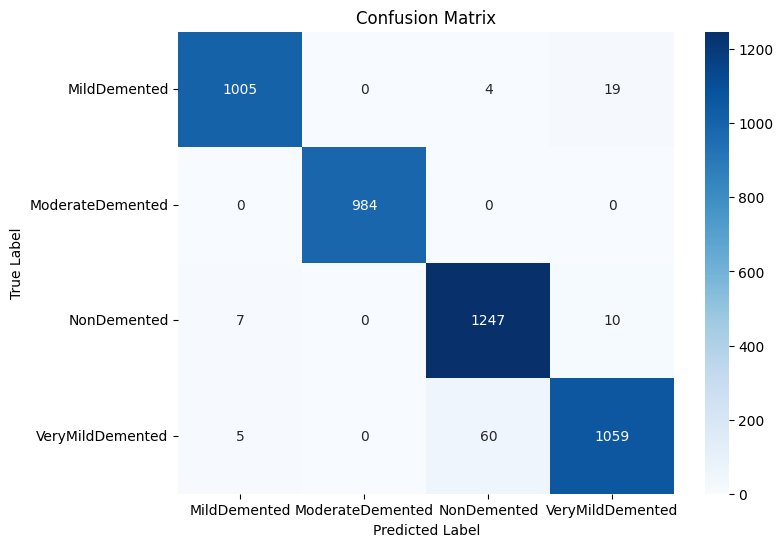

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_names = test_loader.dataset.dataset.classes

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, target_names=class_names)

print(report)

                  precision    recall  f1-score   support

    MildDemented       0.99      0.98      0.98      1028
ModerateDemented       1.00      1.00      1.00       984
     NonDemented       0.95      0.99      0.97      1264
VeryMildDemented       0.97      0.94      0.96      1124

        accuracy                           0.98      4400
       macro avg       0.98      0.98      0.98      4400
    weighted avg       0.98      0.98      0.98      4400



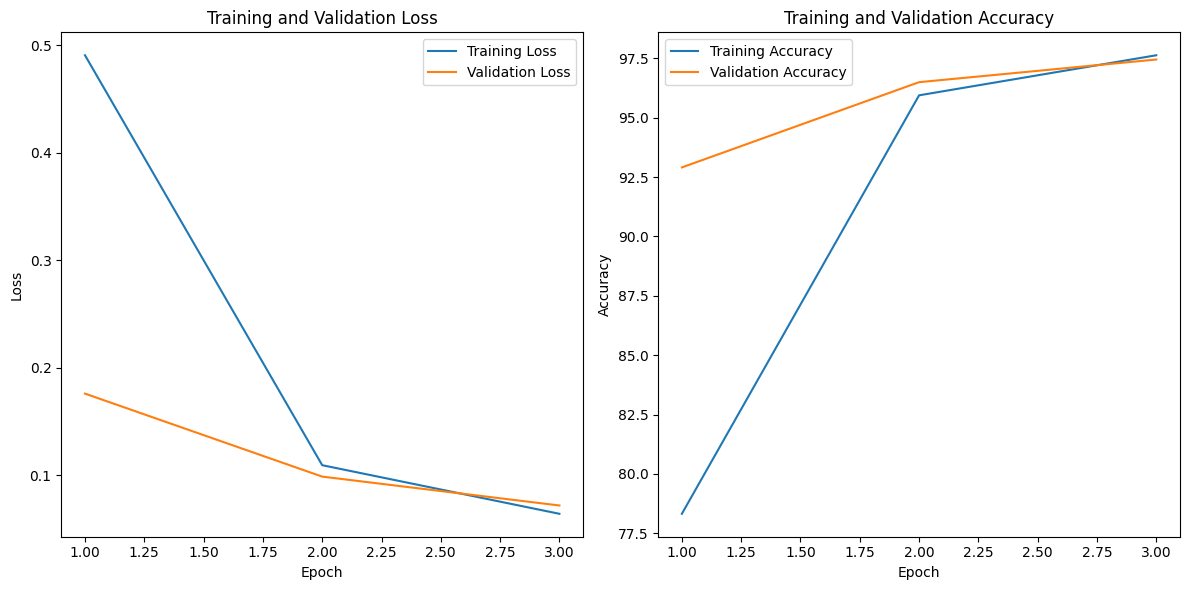

In [ ]:
epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/damodel.pth")